## Article implementation:
### Very Deep Convolutional Networks For Large-Scale Image Recognition
#### Autors: Karen Simonyan & Andrew Zisserman

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

Importing the required libraries

In [3]:
# General libs
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
from pathlib import Path
from datetime import datetime

# Libs for plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torchsummary import summary

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Fixing seed for reproducing results

In [4]:
SEED = 2020

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
MODES = ['train', 'val', 'test']
DEVICE = torch.device("cuda")

### Forming datasets
Create class for future augmentation in training datasets

In [6]:
class GaussianNoise():
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

For collecting images in union dataset from different folders (also folders have the classe names) create special class which will load the files from folders, transforms it and return dataset in pytorch Tensor type 

In [7]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in MODES:
            print(f"{self.mode} is not correct; correct modes: {MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(227, 227)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.RandomApply([transforms.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomApply([GaussianNoise(0, 0.25)], p=0.5)
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(227, 227)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Creating list of file names

In [8]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Create train/test split on the list of file names

In [9]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

Our classes highly unbalanced. Let's find these calsses and sample their data to minimum 150 samples per class.

In [10]:
label_series = pd.Series(list(map(lambda x: x.parent.name, train_files)) )
label_comp = label_series.value_counts()[label_series.value_counts()<150]

to_dict = list(map(lambda x, y: [x.parent.name,y], train_files,train_files))

dict_map = dict()
for name, path in to_dict:
    if name in dict_map:
        dict_map[name].append(path)
    else:
        # create a new array in this slot
        dict_map[name] = [path]

for name, num in zip(label_comp.index, label_comp):
    source = dict_map[name]
    to_upsample = random.choices(source, k=150-num)
    train_files.extend(to_upsample)

Finally create datasets for our neural net

In [11]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
print('Datasets created!')

Datasets created!


In [12]:
def imshow(inp, title='Image from dataset'):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)

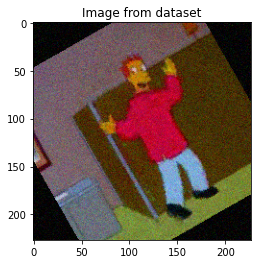

In [13]:
imshow(train_dataset.__getitem__(9000)[0])

### Defining architecture 
Define architecture type D from paper

In [14]:
class VGG_16(nn.Module):
    def __init__(self, input_dim=3):
        super(VGG_16, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_dim, 64 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(64, 128 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(128, 256 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(256, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(512, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512 , 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_block = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 42)
        )
        
    def forward(self, batch):
        x = self.conv_block(batch)
        x = x.view(-1, 7*7*512)
        x = self.linear_block(x)
        return x
    
    def save_model(self):
        torch.save(self.state_dict(), 'VGG_16_'+datetime.now().strftime("%Y%m%d-%H%M%S"))
        return

Define function to set required all gradient true

In [15]:
def setting_gradient(model):
    for i, child in enumerate(model.children()):
        for param in child.parameters():
              param.requires_grad=True
    print('Gradients enabled!')
    return

This big enough neural net required properly weights initialiation

In [16]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Define model and prepare it to learn!

In [17]:
vgg16 = VGG_16()
vgg16.apply(init_weights)
vgg16.to(DEVICE)
setting_gradient(vgg16)

Gradients enabled!


In [18]:
summary(vgg16, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Training model
In original article used Cross Entropy loss function and SGD optimizer with learing rate about 0.01 and dividing it by 10 three times, weight decay was 0.0005.

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [20]:
#Loss function
criterion = torch.nn.CrossEntropyLoss() 
# optimizer SGD
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# Scheduler will reduce learning rate if loss don't decrease at least 3 epoch
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0, verbose=True)

To simplify a little bit our train step, created functions to perform one epoch step for training and validation

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        prediction = model.forward(inputs)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        
        prediction = torch.argmax(prediction, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(prediction == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [22]:
def validation_epoch(model, val_loader, criterion):
    model.train(False)
    running_loss = 0
    running_corrects = 0
    processed_size = 0
    pred_labels = np.array([])
    true_labels = np.array([])
    
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            predictions = model.forward(inputs)
            loss = criterion(predictions, labels)
            pred = torch.argmax(predictions, dim = 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)
        processed_size += inputs.size(0)
        pred_labels = np.hstack((pred_labels, pred.cpu().numpy()))
        true_labels = np.hstack((true_labels, labels.cpu().numpy()))

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    metric_f1 = f1_score(true_labels, pred_labels, average='macro')

    return val_loss, val_acc, metric_f1

In [23]:
def trace_plot(Epoch, train_loss, val_loss, train_acc, val_acc):
    if Epoch != 1:
        fig = make_subplots(rows=2, cols=1)
        x_axis = np.arange(1,Epoch+1)
        
        fig.add_trace(go.Scatter(x=x_axis, y=train_loss,
                            mode='lines',
                            name='train_loss'), row = 1, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=val_loss,
                            mode='lines',
                            name='val_loss'), row = 1, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=train_acc,
                            mode='lines',
                            name='train_acc'), row = 2, col = 1)
        fig.add_trace(go.Scatter(x=x_axis, y=val_acc,
                            mode='lines',
                            name='val_acc'), row = 2, col = 1)
        
        fig.update_layout(height=800, width=1000, title_text='Losses and metrics')
        fig.show()

In [ ]:
Create logger function to know all information about our training process in the future

In [24]:
def log_in_file(file_name, model, optimizer, scheduler, loss,
                epoch, epoch_loss_train, epoch_loss_val,
                epoch_accuracy_train, epoch_accuracy_val,
                epoch_f1_val):
    with open(f'{file_name}.txt', 'a') as the_file:
        if epoch==1:
            the_file.write(f"Starting time to logging: {datetime.now().strftime('%Y%m%d-%H%M%S')} \n")
            the_file.write(f"Network architercure: {model} \n")
            the_file.write(f"Oprimizer: {optimizer} \n")
            the_file.write(f"Scheduler: {scheduler} \n")
            the_file.write(f"Scheduler parameters: {scheduler.state_dict()} \n")
            the_file.write(f"Loss function: {criterion} \n")
            the_file.write(f"SEED for learning: {SEED} \n\n")
            the_file.write(f"Learning process: \n")


        the_file.write(f'Epoch: {epoch}, Train loss: {epoch_loss_train}, Val loss: {epoch_loss_val} \n')
        the_file.write(f'Epoch: {epoch}, Train accuracy {epoch_accuracy_train}, Val accuracy: {epoch_accuracy_val} \n')
        the_file.write(f'Epoch: {epoch}, F1 Val score: {epoch_f1_val} \n\n')
    return

Training loop inside function train. Function also return losses and accuracy for train and validation dataset

In [25]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epoches):
    history_train = []
    accuracy_train = []
    
    history_val = []
    accuracy_val = []

    f1_val = []
    
    for epoch in range(1, epoches+1):
        print(f'Epoch: {epoch}')
        epoch_loss_train, epoch_accuracy_train = fit_epoch(model, train_loader, criterion, optimizer)
        history_train.append(epoch_loss_train)
        accuracy_train.append(epoch_accuracy_train)
    
        epoch_loss_val, epoch_accuracy_val, epoch_f1_val = validation_epoch(model, val_loader, criterion)
        history_val.append(epoch_loss_val)
        accuracy_val.append(epoch_accuracy_val)
        f1_val.append(epoch_f1_val)
        
        scheduler.step(epoch_loss_val)
        
        # trace_plot(epoch, history_train, history_val, accuracy_train, accuracy_val)
        log_in_file('VGG16_logs', model, optimizer, scheduler, criterion,
                epoch, epoch_loss_train, epoch_loss_val,
                epoch_accuracy_train, epoch_accuracy_val,
                epoch_f1_val)
        
        print('')
        print(f'Epoch: {epoch}, Train loss: {epoch_loss_train}, Val loss: {epoch_loss_val}')
        print(f'Epoch: {epoch}, Train accuracy {epoch_accuracy_train}, Val accuracy: {epoch_accuracy_val}',
              f'Val F1 score: {epoch_f1_val} \n\n')
        
    return history_train, history_val, accuracy_train, accuracy_val, f1_val

Train our model!

In [26]:
EPOCHES = 40
history_train, history_val, accuracy_train, accuracy_val, f1_val = train(vgg16,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         scheduler,
                                                                         EPOCHES)

Epoch: 1




Epoch: 1, Train loss: 3.386805742844633, Val loss: 3.1293260780599765
Epoch: 1, Train accuracy 0.09365777604543683, Val accuracy: 0.16641192204814673 Val F1 score: 0.035215943504624925 


Epoch: 2




Epoch: 2, Train loss: 3.0616845917984494, Val loss: 2.6733176732819457
Epoch: 2, Train accuracy 0.17990979453198952, Val accuracy: 0.27990064959877725 Val F1 score: 0.09669586388202646 


Epoch: 3




Epoch: 3, Train loss: 2.6750879106638963, Val loss: 2.2714978459685824
Epoch: 3, Train accuracy 0.2715073222339774, Val accuracy: 0.38135269392434085 Val F1 score: 0.17703676243736538 


Epoch: 4




Epoch: 4, Train loss: 2.2447709026020175, Val loss: 1.6676447034383213
Epoch: 4, Train accuracy 0.38883011303524695, Val accuracy: 0.5555980129919755 Val F1 score: 0.30188757892949586 


Epoch: 5




Epoch: 5, Train loss: 1.8360099831842966, Val loss: 1.4310168745320035
Epoch: 5, Train accuracy 0.48744362158249344, Val accuracy: 0.5941918226977455 Val F1 score: 0.3421095806755363 


Epoch: 6




Epoch: 6, Train loss: 1.513573487854142, Val loss: 1.3172466623723895
Epoch: 6, Train accuracy 0.5706331087477031, Val accuracy: 0.6400458540313336 Val F1 score: 0.41673708812866217 


Epoch: 7




Epoch: 7, Train loss: 1.2794747320804758, Val loss: 0.9773325131146289
Epoch: 7, Train accuracy 0.6370621972270171, Val accuracy: 0.73079862437906 Val F1 score: 0.5263622691864894 


Epoch: 8




Epoch: 8, Train loss: 1.074258414765324, Val loss: 0.8708063818181249
Epoch: 8, Train accuracy 0.6955843866584999, Val accuracy: 0.7611769201375621 Val F1 score: 0.5576206455379437 


Epoch: 9




Epoch: 9, Train loss: 0.9249148476899776, Val loss: 0.7430473116913687
Epoch: 9, Train accuracy 0.7400746143994654, Val accuracy: 0.8030187237294613 Val F1 score: 0.6154798672237034 


Epoch: 10




Epoch: 10, Train loss: 0.7960531563355003, Val loss: 0.6704931527000372
Epoch: 10, Train accuracy 0.7737624589342391, Val accuracy: 0.815437523882308 Val F1 score: 0.6282111693328299 


Epoch: 11




Epoch: 11, Train loss: 0.6854161843703129, Val loss: 0.6461422602821498
Epoch: 11, Train accuracy 0.8090094103235147, Val accuracy: 0.826518914787925 Val F1 score: 0.6438439286499925 


Epoch: 12




Epoch: 12, Train loss: 0.604634387232664, Val loss: 0.5623264776462356
Epoch: 12, Train accuracy 0.8300573528592906, Val accuracy: 0.8553687428353076 Val F1 score: 0.6792932728214901 


Epoch: 13




Epoch: 13, Train loss: 0.5442606878112038, Val loss: 0.5175866497054918
Epoch: 13, Train accuracy 0.8477643521354196, Val accuracy: 0.8630110813909057 Val F1 score: 0.7258512573328292 


Epoch: 14




Epoch: 14, Train loss: 0.47301620411424145, Val loss: 0.49540752063145566
Epoch: 14, Train accuracy 0.8657497633498524, Val accuracy: 0.8742835307604127 Val F1 score: 0.7181080288351303 


Epoch: 15




Epoch: 15, Train loss: 0.4387724992294169, Val loss: 0.5263588451728777
Epoch: 15, Train accuracy 0.877164652820313, Val accuracy: 0.8601452044325564 Val F1 score: 0.7032157735811497 


Epoch: 16




Epoch: 16, Train loss: 0.41620571240828375, Val loss: 0.47763042412143103
Epoch: 16, Train accuracy 0.8799487722033521, Val accuracy: 0.8754298815437523 Val F1 score: 0.7338161367297372 


Epoch: 17




Epoch: 17, Train loss: 0.35281578475664704, Val loss: 0.4511977720907457
Epoch: 17, Train accuracy 0.9016092210033966, Val accuracy: 0.8815437523882308 Val F1 score: 0.7607313313573305 


Epoch: 18




Epoch: 18, Train loss: 0.3437455263990915, Val loss: 0.37722099736122217
Epoch: 18, Train accuracy 0.9019989977170221, Val accuracy: 0.9031333588077952 Val F1 score: 0.7581869347183473 


Epoch: 19




Epoch: 19, Train loss: 0.297098434668712, Val loss: 0.40542476273216177
Epoch: 19, Train accuracy 0.9160309594075394, Val accuracy: 0.8977837218188766 Val F1 score: 0.7575142287613296 


Epoch: 20




Epoch: 20, Train loss: 0.28864217045126744, Val loss: 0.35384078327826884
Epoch: 20, Train accuracy 0.9168661952224512, Val accuracy: 0.9128773404661826 Val F1 score: 0.7746536965779983 


Epoch: 21




Epoch: 21, Train loss: 0.26333717324532074, Val loss: 0.45807417264912115
Epoch: 21, Train accuracy 0.9242162703936745, Val accuracy: 0.8878486816965991 Val F1 score: 0.7424508728597969 


Epoch: 22




Epoch: 22, Train loss: 0.257027987112174, Val loss: 0.41646090619063897
Epoch: 22, Train accuracy 0.9257753772481764, Val accuracy: 0.8952999617883072 Val F1 score: 0.747705575810681 


Epoch: 23




Epoch: 23, Train loss: 0.23036362463766552, Val loss: 0.4058447510038207
Epoch: 23, Train accuracy 0.9329027228687566, Val accuracy: 0.903706534199465 Val F1 score: 0.7809378270892984 


Epoch: 24




Epoch: 24, Train loss: 0.22089008838759744, Val loss: 0.3324462981865431
Epoch: 24, Train accuracy 0.935352747925831, Val accuracy: 0.9203286205578907 Val F1 score: 0.8159522057075528 


Epoch: 25




Epoch: 25, Train loss: 0.20043260842421498, Val loss: 0.34325523717192963
Epoch: 25, Train accuracy 0.9411993986302133, Val accuracy: 0.9203286205578907 Val F1 score: 0.7983811492855976 


Epoch: 26




Epoch: 26, Train loss: 0.19750479759246126, Val loss: 0.37673233404476586
Epoch: 26, Train accuracy 0.9418675872821427, Val accuracy: 0.9195643867023309 Val F1 score: 0.8125819306781229 


Epoch: 27




Epoch: 27, Train loss: 0.196647868467284, Val loss: 0.3534972697587518
Epoch: 27, Train accuracy 0.9420903168327858, Val accuracy: 0.9214749713412305 Val F1 score: 0.812988941695232 


Epoch: 28



Epoch    28: reducing learning rate of group 0 to 1.0000e-03.

Epoch: 28, Train loss: 0.1894438510405021, Val loss: 0.3839135628234898
Epoch: 28, Train accuracy 0.9445403418898602, Val accuracy: 0.9126862820022927 Val F1 score: 0.8008423450049246 


Epoch: 29




Epoch: 29, Train loss: 0.08381163722137625, Val loss: 0.2895195003959073
Epoch: 29, Train accuracy 0.976390667631828, Val accuracy: 0.9428735192969049 Val F1 score: 0.8365709026997243 


Epoch: 30




Epoch: 30, Train loss: 0.06925639387188406, Val loss: 0.2863884148510713
Epoch: 30, Train accuracy 0.980511164318726, Val accuracy: 0.9430645777607948 Val F1 score: 0.8403842804815683 


Epoch: 31




Epoch: 31, Train loss: 0.06220986393757787, Val loss: 0.28448015170433066
Epoch: 31, Train accuracy 0.9832396013141044, Val accuracy: 0.9447841039358044 Val F1 score: 0.8432558128807799 


Epoch: 32




Epoch: 32, Train loss: 0.054834574959237485, Val loss: 0.29293445186290207
Epoch: 32, Train accuracy 0.9846873433932847, Val accuracy: 0.9442109285441345 Val F1 score: 0.8346746103166955 


Epoch: 33




Epoch: 33, Train loss: 0.052758751922150196, Val loss: 0.29087301996494913
Epoch: 33, Train accuracy 0.9839077899660338, Val accuracy: 0.946312571646924 Val F1 score: 0.8430897030699838 


Epoch: 34




Epoch: 34, Train loss: 0.051020154962121686, Val loss: 0.29245473048445103
Epoch: 34, Train accuracy 0.9850771201069102, Val accuracy: 0.9449751623996943 Val F1 score: 0.8390770294550018 


Epoch: 35



Epoch    35: reducing learning rate of group 0 to 1.0000e-04.

Epoch: 35, Train loss: 0.038590197549982275, Val loss: 0.30972540921207414
Epoch: 35, Train accuracy 0.9882510162035748, Val accuracy: 0.9466946885747038 Val F1 score: 0.8451473835029685 


Epoch: 36




Epoch: 36, Train loss: 0.04146927117606419, Val loss: 0.3060311722545324
Epoch: 36, Train accuracy 0.9880839690405925, Val accuracy: 0.9449751623996943 Val F1 score: 0.8388408877004727 


Epoch: 37




Epoch: 37, Train loss: 0.04089594751920461, Val loss: 0.30430808732123105
Epoch: 37, Train accuracy 0.9883066985912355, Val accuracy: 0.9453572793274742 Val F1 score: 0.8432977808245904 


Epoch: 38




Epoch: 38, Train loss: 0.04149361984594039, Val loss: 0.304487944449297
Epoch: 38, Train accuracy 0.9877498747146277, Val accuracy: 0.9453572793274742 Val F1 score: 0.8414795126855933 


Epoch: 39



Epoch    39: reducing learning rate of group 0 to 1.0000e-05.

Epoch: 39, Train loss: 0.039930781366238115, Val loss: 0.30424546780770045
Epoch: 39, Train accuracy 0.9884180633665571, Val accuracy: 0.9447841039358044 Val F1 score: 0.8401127171080697 


Epoch: 40




Epoch: 40, Train loss: 0.04142086520146767, Val loss: 0.3040193968264256
Epoch: 40, Train accuracy 0.9878612394899493, Val accuracy: 0.9447841039358044 Val F1 score: 0.8401127171080697 




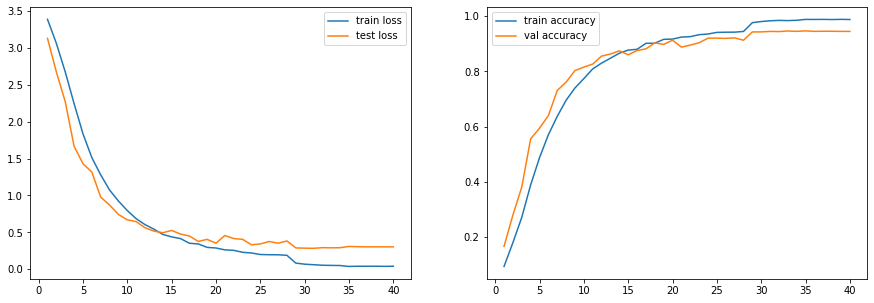

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(np.arange(1,EPOCHES+1), history_train, label='train loss')
ax[0].plot(np.arange(1,EPOCHES+1), history_val, label='test loss')
ax[0].legend()

ax[1].plot(np.arange(1,EPOCHES+1), accuracy_train, label='train accuracy')
ax[1].plot(np.arange(1,EPOCHES+1), accuracy_val, label='val accuracy')
ax[1].legend()

Save model for future using

In [28]:
vgg16.save_model()

Model stopped learn about 40 epoch with F1 score 84%